### Using CNN (VGG19, MobileNetV2)

In [46]:
import numpy as np
import pandas as pd

from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.backend import epsilon
import tensorflow as tf 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import cv2

from tqdm.notebook import tqdm_notebook as tqdm

import os

In [8]:
real = "./data/real_and_fake_face_detection/real_and_fake_face/training_real/"
fake = "./data/real_and_fake_face_detection/real_and_fake_face/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

### Check the real, fake Images

In [12]:
def load_img(path):
  image = cv2.imread(path)
  image = cv2.resize(image, (224, 224))
  return image[...,::-1]

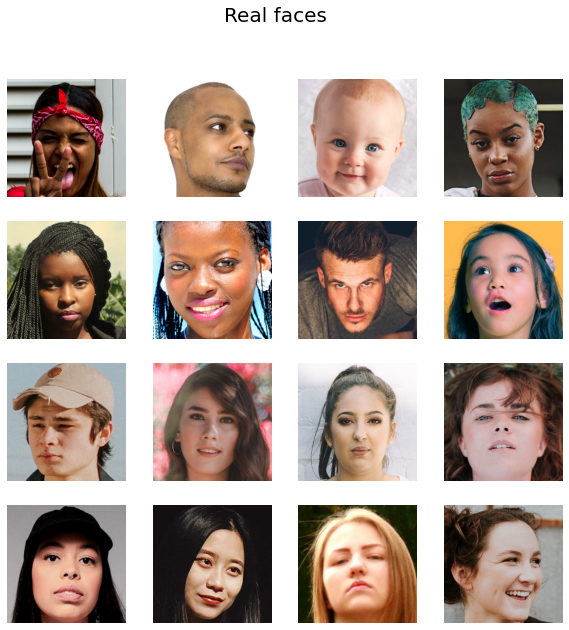

In [15]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(load_img(real + real_path[i]), cmap='gray')
  plt.suptitle("Real faces", fontsize=20)
  plt.axis('off')
  
plt.show()

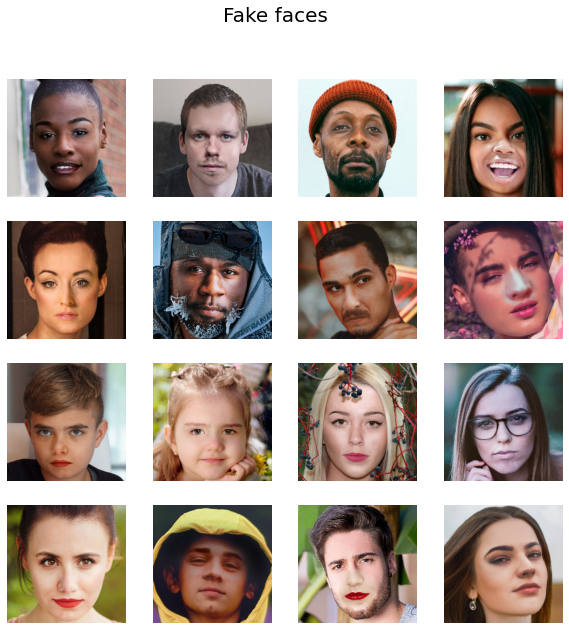

In [16]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
  plt.suptitle("Fake faces", fontsize=20)
  plt.axis('off')
  
plt.show()

In [17]:
dataset_path = "./data/real_and_fake_face_detection/real_and_fake_face"

### Data Agumentaion

In [18]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                   validation_split=0.2)

In [19]:
train = data_with_aug.flow_from_directory(dataset_path,
                                        class_mode="binary",
                                        target_size=(96, 96),
                                        batch_size=32,
                                        subset="training")

Found 1633 images belonging to 2 classes.


In [20]:
val = data_with_aug.flow_from_directory(dataset_path,
                                        class_mode="binary",
                                        target_size=(96, 96),
                                        batch_size=32,
                                        subset="validation")

Found 408 images belonging to 2 classes.


In [21]:
mnet = MobileNetV2(include_top = False, weights="imagenet", input_shape=(96, 96, 3))

2022-05-02 17:57:46.834170: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-02 17:57:47.557601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30970 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


9420800/9406464 [==============================] - 1s 0us/step


In [23]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation='relu'),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation='relu'),
                    Dropout(0.1),
                    Dense(32, activation='relu'),
                    Dropout(0.3),
                    Dense(2, activation='softmax')])

model.layers[0].trainable = False
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

### Callbacks

In [25]:
def scheduler(epoch):
  if epoch <= 2:
    return 0.001
  elif epoch > 2 and epoch <= 15:
    return 0.0001
  else:
    return 0.00001
  
lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [31]:
hist = model.fit_generator(train, 
                              epochs=20,
                              callbacks=[lr_callbacks],
                              validation_data=val)

/home/c4nd0it/anaconda3/envs/keras_env/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
52/52 [==============================] - 16s 318ms/step - loss: 0.4211 - accuracy: 0.8108 - val_loss: 1.5215 - val_accuracy: 0.5147
Epoch 2/20
52/52 [==============================] - 16s 307ms/step - loss: 0.4675 - accuracy: 0.7753 - val_loss: 1.0287 - val_accuracy: 0.5466
Epoch 3/20
52/52 [==============================] - 16s 312ms/step - loss: 0.4217 - accuracy: 0.8034 - val_loss: 1.2011 - val_accuracy: 0.4902
Epoch 4/20
52/52 [==============================] - 16s 310ms/step - loss: 0.3623 - accuracy: 0.8402 - val_loss: 1.0562 - val_accuracy: 0.5123
Epoch 5/20
52/52 [==============================] - 16s 310ms/step - loss: 0.3295 - accuracy: 0.8549 - val_loss: 1.0565 - val_accuracy: 0.5098
Epoch 6/20
52/52 [==============================] - 16s 307ms/step - loss: 0.2996 - accuracy: 0.8714 - val_loss: 1.1015 - val_accuracy: 0.5147
Epoch 7/20
52/52 [==============================] - 16s 311ms/step - loss: 0.2785 - accuracy: 0.8836 - val_loss: 1.2013 - val_accuracy: 0.5172

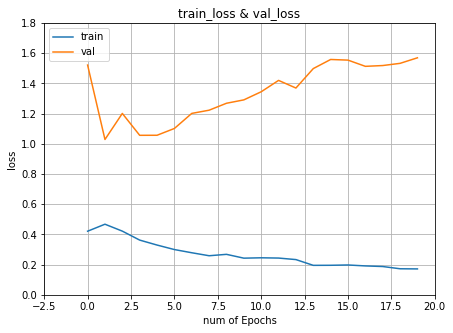

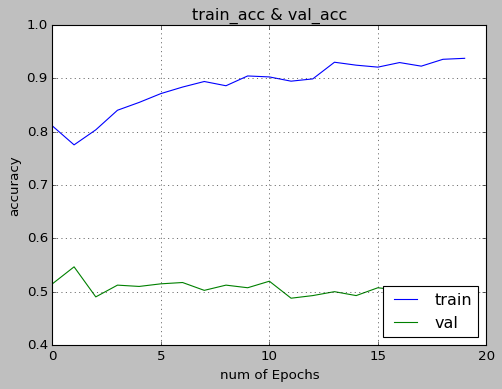

In [35]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1, figsize=(7, 5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss & val_loss')
plt.grid(True)
plt.legend(['train', 'val'])
plt.style.use('classic')

plt.figure(2, figsize=(7, 5))
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc & val_acc')
plt.grid(True)
plt.legend(['train','val'], loc=4)
plt.style.use(['classic'])

### VGG16

In [36]:
train = data_with_aug.flow_from_directory(dataset_path,
                                        class_mode="binary",
                                        target_size=(224, 224),
                                        batch_size=98,
                                        subset="training")

val = data_with_aug.flow_from_directory(dataset_path,
                                        class_mode="binary",
                                        target_size=(224, 224),
                                        batch_size=98,
                                        subset="validation")

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [38]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 5s 0us/step


In [39]:
vgg16_model.output[-1]

<KerasTensor: shape=(7, 7, 512) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [41]:
model = Sequential([
  vgg16_model,
  Flatten(),
  # GlobalAveragePooling2D(),
  # Dense(512, activation='relu'),
  # BatchNormalization(),
  # Dropout(0.3),
  # Dense(128, activation='relu'),
  # Dropout(0.1),
  # Dense(32, activation='relu'),
  # Dropout(0.3),
  Dense(2, activation='softmax'),
])

model.layers[0].trainable = False
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics="accuracy")

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [42]:
hist = model.fit(train,
                 epochs=20,
                 callbacks=[lr_callbacks],
                 validation_data=val)

Epoch 1/20
17/17 [==============================] - 24s 1s/step - loss: 1.0868 - accuracy: 0.5554 - val_loss: 0.9574 - val_accuracy: 0.5539
Epoch 2/20
17/17 [==============================] - 19s 1s/step - loss: 0.6424 - accuracy: 0.6852 - val_loss: 0.8180 - val_accuracy: 0.5882
Epoch 3/20
17/17 [==============================] - 18s 1s/step - loss: 0.5149 - accuracy: 0.7587 - val_loss: 0.9394 - val_accuracy: 0.5441
Epoch 4/20
17/17 [==============================] - 18s 1s/step - loss: 0.4662 - accuracy: 0.7887 - val_loss: 0.7837 - val_accuracy: 0.5735
Epoch 5/20
17/17 [==============================] - 18s 1s/step - loss: 0.4439 - accuracy: 0.7961 - val_loss: 0.7971 - val_accuracy: 0.5613
Epoch 6/20
17/17 [==============================] - 18s 1s/step - loss: 0.4391 - accuracy: 0.8016 - val_loss: 0.8226 - val_accuracy: 0.5490
Epoch 7/20
17/17 [==============================] - 19s 1s/step - loss: 0.4393 - accuracy: 0.8047 - val_loss: 0.8012 - val_accuracy: 0.5809
Epoch 8/20
17/17 [==

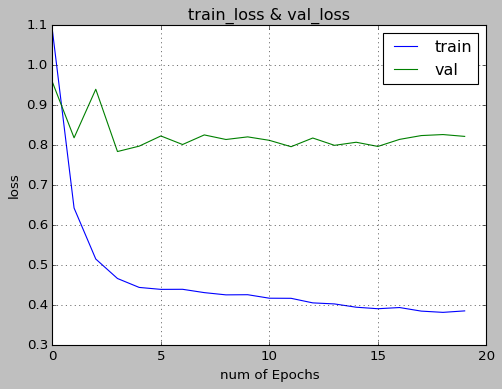

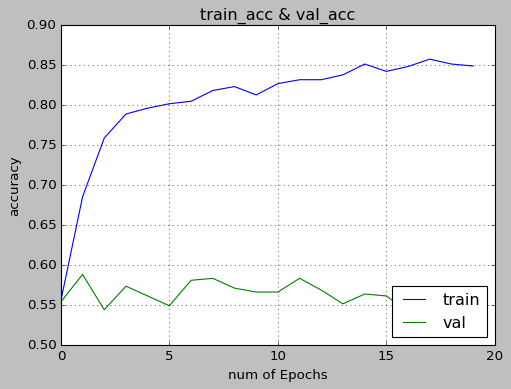

In [43]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1, figsize=(7, 5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss & val_loss')
plt.grid(True)
plt.legend(['train', 'val'])
plt.style.use('classic')

plt.figure(2, figsize=(7, 5))
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc & val_acc')
plt.grid(True)
plt.legend(['train','val'], loc=4)
plt.style.use(['classic'])

### Predictions

In [44]:
predictions = model.predict_generator(val)

/home/c4nd0it/anaconda3/envs/keras_env/lib/python3.8/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


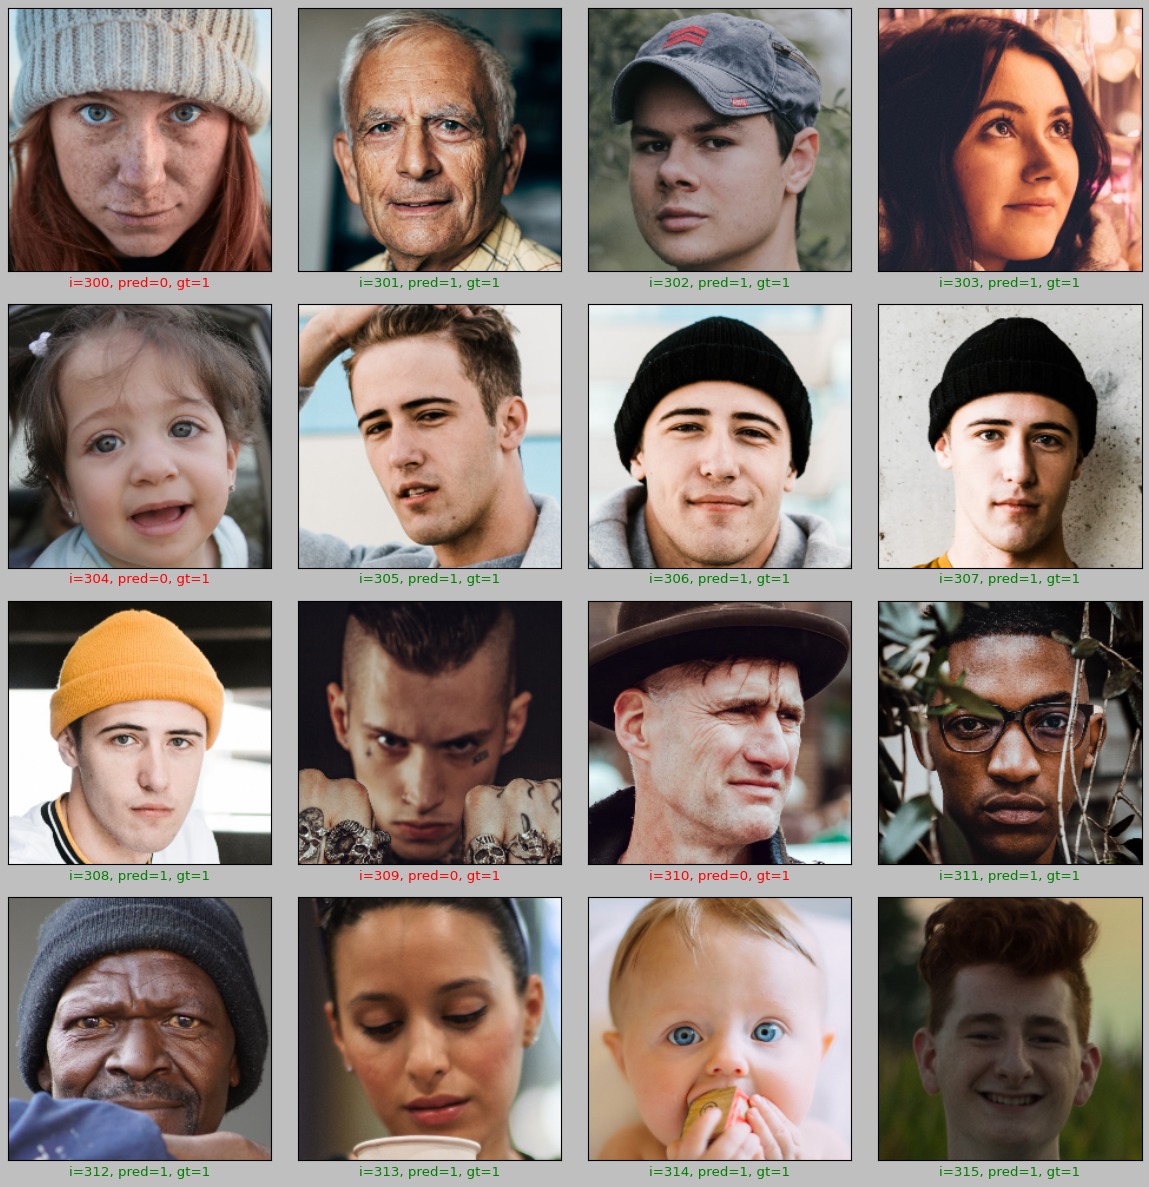

In [51]:
val_path = "./data/real_and_fake_face_detection/real_and_fake_face/"

plt.figure(figsize=(15, 15))
start_index = 300
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  preds = np.argmax(predictions[[start_index + i]])
  
  gt = val.filenames[start_index + i][9:13]
  if gt == "fake":
    gt = 0
  else:
    gt = 1
    
  if preds != gt:
    col = "r"
  else:
    col = "g"
    
  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i, preds, gt), color=col)
  plt.imshow(load_img(val_path+val.filenames[start_index + i]))
  plt.tight_layout()
  
plt.show()